In [1]:
import tensorflow as tf
import os
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    EarlyStopping,
    ReduceLROnPlateau,
)

In [2]:
path = kagglehub.dataset_download("anshtanwar/pets-facial-expression-dataset")

print("Path to dataset files:", path)
path_2 = os.path.join(path, "Master Folder")

train_dir = os.path.join(path, "Master Folder", "train")
val_dir = os.path.join(path, "Master Folder", "valid")
test_dir = os.path.join(path, "Master Folder", "test")

Path to dataset files: /kaggle/input/pets-facial-expression-dataset


In [3]:
img_size = 299  # Inception V3 requires 299x299 input
batch_size = 32

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(299, 299),  # Inception V3 input size
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Don't shuffle test data for consistent evaluation
)


Found 1000 images belonging to 4 classes.
Found 36 images belonging to 4 classes.
Found 38 images belonging to 4 classes.


In [9]:
num_classes = len(train_generator.class_indices)
print(f"Number of classes: {num_classes}")

Number of classes: 4


In [ ]:
def create_inception_transfer_model(num_classes):
    # Load pre-trained Inception V3 model without top layer
    base_model = InceptionV3(
        weights='imagenet', # Use pre-trained ImageNet weights
        include_top=False,  # Exclude the final fully connected layer
        input_shape=(299, 299, 3)
    )

    # Freeze all layers in the base model to prevent training them initially
    base_model.trainable = False

    # Add custom classification head
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Return both the full model and the base model separately (for fine-tuning)
    return model, base_model

In [ ]:
# Create the model and freeze the base model
model, base_model = create_inception_transfer_model(num_classes)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")


Total parameters: 22,984,228
Trainable parameters: 1,181,444


In [13]:
# Stage 1: Feature Extraction Training (frozen base model)
print("\nStage 1: Feature Extraction Training")
print("="*50)



Stage 1: Feature Extraction Training


In [14]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# Train only the new classification head (base model is frozen)
history_stage1 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=15,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step - accuracy: 0.3168 - loss: 1.6671 - val_accuracy: 0.4375 - val_loss: 1.4237
Epoch 2/15
 1/31 ━━━━━━━━━━━━━━━━━━━━ 2:36 5s/step - accuracy: 0.3125 - loss: 1.7520

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 176ms/step - accuracy: 0.3125 - loss: 1.7520 - val_accuracy: 0.3438 - val_loss: 1.4762
Epoch 3/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 202s 7s/step - accuracy: 0.4527 - loss: 1.2740 - val_accuracy: 0.3750 - val_loss: 1.2408
Epoch 4/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 187ms/step - accuracy: 0.4375 - loss: 1.2133 - val_accuracy: 0.4062 - val_loss: 1.2673
Epoch 5/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 262s 7s/step - accuracy: 0.4688 - loss: 1.1789 - val_accuracy: 0.4062 - val_loss: 1.3168
Epoch 6/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 189ms/step - accuracy: 0.3438 - loss: 1.2759 - val_accuracy: 0.4688 - val_loss: 1.2243
Epoch 7/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 202s 5s/step - accuracy: 0.4983 - loss: 1.1436 - val_accuracy: 0.3750 - val_loss: 1.3703
Epoch 8/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 0.4375 - loss: 1.2771 - val_accuracy: 0.3125 - val_loss: 1.3585
Epoch 9/15
31/31 ━━━━━━━━━━━━━━━━━━━━ 159s 5s/step - accuracy: 0.5506 - loss: 1.0666 - val_accuracy: 0.4062 - val_

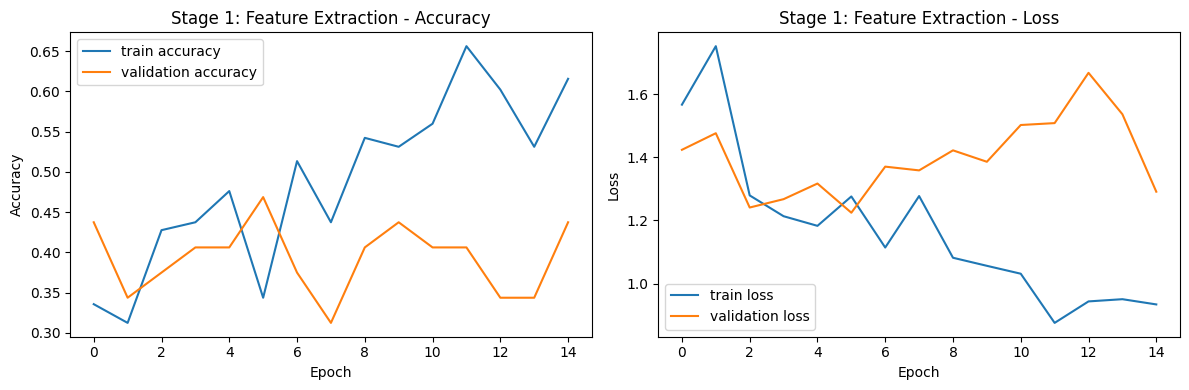

In [17]:
# Plot Stage 1 training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_stage1.history['accuracy'], label='train accuracy')
plt.plot(history_stage1.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Stage 1: Feature Extraction - Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_stage1.history['loss'], label='train loss')
plt.plot(history_stage1.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Stage 1: Feature Extraction - Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
# Evaluate after Stage 1
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Stage 1 Test Accuracy: {test_acc:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 913ms/step - accuracy: 0.3810 - loss: 1.4219
Stage 1 Test Accuracy: 0.3684


In [19]:
# Stage 2: Fine-tuning (unfreeze some layers)
print("\nStage 2: Fine-tuning")
print("="*50)


Stage 2: Fine-tuning


In [ ]:
# Unfreeze the base model to fine-tune some of its layers
base_model.trainable = True

In [ ]:
# Fine-tune from this layer onwards (unfreeze top layers)
fine_tune_at = len(base_model.layers) // 2

In [ ]:
# Freeze the bottom half of the base model (keep them untrainable)
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

print(f"Unfreezing layers from layer {fine_tune_at} onwards")
print(f"Total layers: {len(base_model.layers)}")
print(f"Trainable parameters after unfreezing: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

Unfreezing layers from layer 155 onwards
Total layers: 311
Trainable parameters after unfreezing: 17,970,884


In [23]:
# Compile with lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001/10),  # Much lower learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train the model again — now also updating the top pre-trained layers
history_stage2 = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    epochs=10,
    verbose=1
)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 316s 10s/step - accuracy: 0.4670 - loss: 1.2658 - val_accuracy: 0.4062 - val_loss: 1.5443
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 20s 373ms/step - accuracy: 0.5312 - loss: 1.0902 - val_accuracy: 0.4688 - val_loss: 1.4095
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 288s 9s/step - accuracy: 0.5366 - loss: 1.0464 - val_accuracy: 0.4375 - val_loss: 1.4581
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step - accuracy: 0.5312 - loss: 1.0206 - val_accuracy: 0.4062 - val_loss: 1.5549
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 321s 10s/step - accuracy: 0.6295 - loss: 0.9414 - val_accuracy: 0.4375 - val_loss: 1.5546
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 379ms/step - accuracy: 0.5938 - loss: 0.9339 - val_accuracy: 0.4375 - val_loss: 1.5669
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 382s 11s/step - accuracy: 0.6061 - loss: 0.9202 - val_accuracy: 0.4375 - val_loss: 1.4586
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 21s 382ms/step - accuracy: 0.6250 - loss: 0.8025 - val_accuracy:

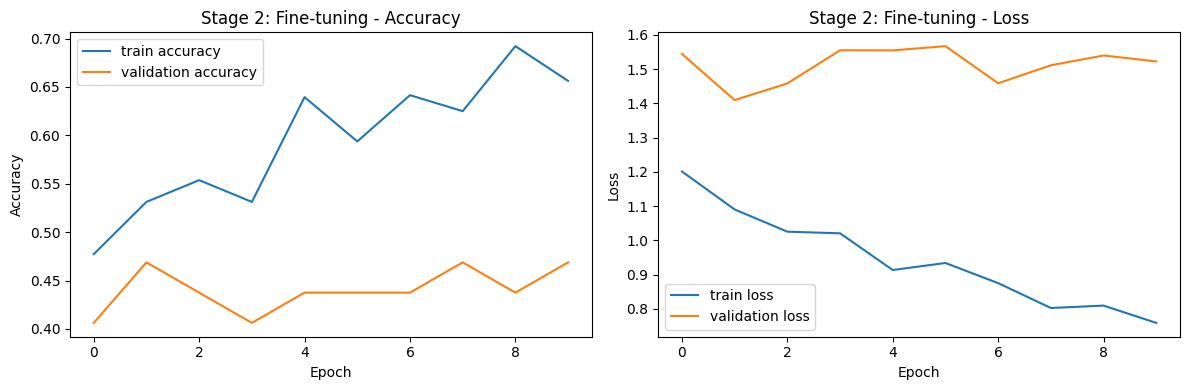

In [25]:
# Plot Stage 2 training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_stage2.history['accuracy'], label='train accuracy')
plt.plot(history_stage2.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Stage 2: Fine-tuning - Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_stage2.history['loss'], label='train loss')
plt.plot(history_stage2.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Stage 2: Fine-tuning - Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Final Test Accuracy after Transfer Learning: {test_acc:.4f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 998ms/step - accuracy: 0.3986 - loss: 1.5436
Final Test Accuracy after Transfer Learning: 0.3947


In [27]:
# Predict classes on test set
test_generator.reset()
test_steps = np.ceil(test_generator.samples / batch_size)
y_pred_probs = model.predict(test_generator, steps=int(test_steps), verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_generator.classes[:len(y_pred)]

2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step


In [28]:
# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))


Classification Report:
              precision    recall  f1-score   support

       Angry       0.50      0.80      0.62        10
       Other       0.00      0.00      0.00         6
         Sad       0.33      0.27      0.30        11
       happy       0.40      0.36      0.38        11

    accuracy                           0.39        38
   macro avg       0.31      0.36      0.32        38
weighted avg       0.34      0.39      0.36        38



Text(0.5, 1.0, 'Confusion Matrix - Transfer Learning Inception V3')

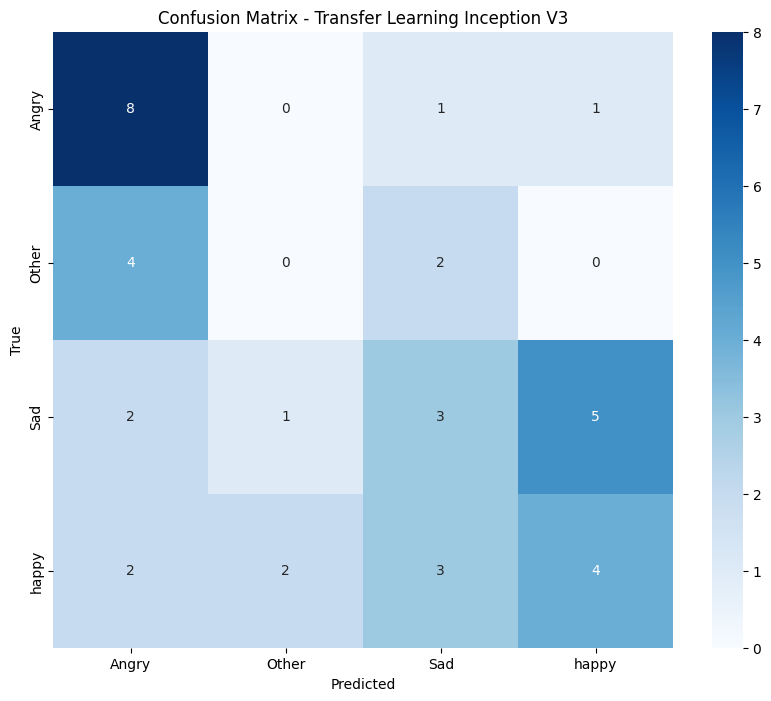

In [29]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Transfer Learning Inception V3')